In [1]:
import os
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

In [2]:
print("Torch Version",torch.__version__)

Torch Version 0.4.1


In [3]:
main_dir = "data/augmented"
data_dir = os.path.join(main_dir, "Wheat")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/augmented\Wheat\train 0
data/augmented\Wheat\train\loged 3360
data/augmented\Wheat\train\Nonloged 6240
******************************
data/augmented\Wheat\valid 0
data/augmented\Wheat\valid\loged 848
data/augmented\Wheat\valid\Nonloged 1552
******************************
data/augmented\Wheat\test 0
data/augmented\Wheat\test\loged 64
data/augmented\Wheat\test\Nonloged 122


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [6]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.RandomResizedCrop(299),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
#                                       transforms.CenterCrop(224),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

test_transform = transforms.Compose([transforms.RandomResizedCrop(299),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

train_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

valid_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

test_dataset =  torchvision.datasets.ImageFolder(test_dir,
                                                transform=test_transform)

batch_size = 16
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset), 
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

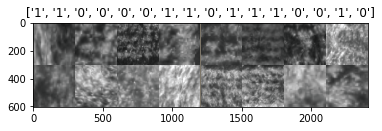

In [7]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[str(x.item()) for x in classes])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print(dataset_sizes)
print(device)

{'valid': 9600, 'train': 9600, 'test': 186}
cuda:0


In [30]:
num_classes = 2
model = torchvision.models.inception_v3(pretrained=True)
model.aux_logits=False

for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)    
    
fc = torch.nn.Sequential(
    nn.Dropout(p=0.15),
    nn.LeakyReLU(0.1),
    nn.Linear(num_features, 2))
model.fc = fc
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(fc.parameters())

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
#         print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print(".", end="")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
if torch.cuda.is_available():
    print("Cuda is available.")
    model = torch.nn.DataParallel(model).cuda();

model = train_model(model, criterion, optimizer, scheduler=None, num_epochs=50)

Cuda is available.
Epoch 0/49
--------------------
train Loss: 0.6974 Acc: 0.5319
valid Loss: 0.6864 Acc: 0.5498

Epoch 1/49
--------------------
train Loss: 0.6993 Acc: 0.5273
valid Loss: 0.6849 Acc: 0.5572

Epoch 2/49
--------------------
train Loss: 0.6987 Acc: 0.5261
valid Loss: 0.6812 Acc: 0.5713

Epoch 3/49
--------------------
train Loss: 0.7011 Acc: 0.5251
valid Loss: 0.6832 Acc: 0.5630

Epoch 4/49
--------------------
train Loss: 0.6988 Acc: 0.5339
valid Loss: 0.6833 Acc: 0.5621

Epoch 5/49
--------------------
train Loss: 0.6977 Acc: 0.5281
valid Loss: 0.6834 Acc: 0.5661

Epoch 6/49
--------------------
train Loss: 0.6961 Acc: 0.5300
valid Loss: 0.6856 Acc: 0.5481

Epoch 7/49
--------------------
train Loss: 0.7001 Acc: 0.5215
valid Loss: 0.6810 Acc: 0.5755

Epoch 8/49
--------------------
train Loss: 0.6976 Acc: 0.5323
valid Loss: 0.6853 Acc: 0.5523

Epoch 9/49
--------------------
train Loss: 0.6968 Acc: 0.5315
valid Loss: 0.6839 Acc: 0.5656

Epoch 10/49
-------------------

In [33]:
torch.save(model.state_dict(), "models/10.Wheat-Inception_V3_augmented.pth")

In [34]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 65.5914
Test Loss: 0.6704


Confusion Matrix
[[93 29]
 [35 29]]


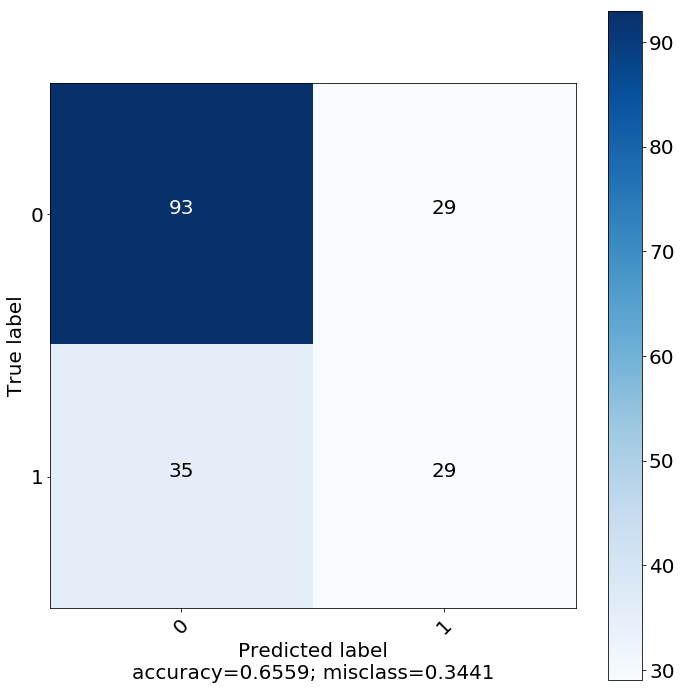

In [35]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))

labels = ['0', '1']

plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [36]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[93 29]
 [35 29]]


In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[93 29]
 [35 29]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       122
           1       0.50      0.45      0.48        64

   micro avg       0.66      0.66      0.66       186
   macro avg       0.61      0.61      0.61       186
weighted avg       0.65      0.66      0.65       186



In [38]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  65.59139784946237
Sensitivity :  72.65625
Specificity :  50.0


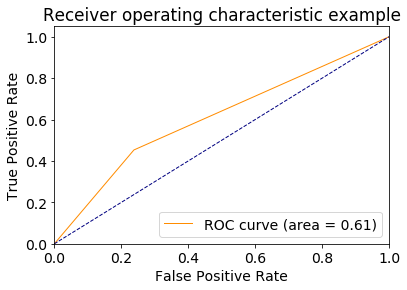

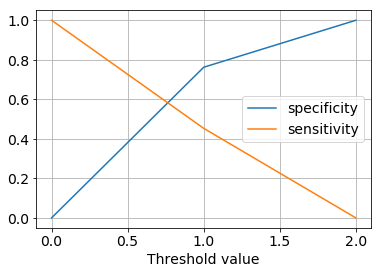

In [39]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [40]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

Conv2d_1a_3x3.conv.weight False
Conv2d_1a_3x3.bn.weight False
Conv2d_1a_3x3.bn.bias False
Conv2d_2a_3x3.conv.weight False
Conv2d_2a_3x3.bn.weight False
Conv2d_2a_3x3.bn.bias False
Conv2d_2b_3x3.conv.weight False
Conv2d_2b_3x3.bn.weight False
Conv2d_2b_3x3.bn.bias False
Conv2d_3b_1x1.conv.weight False
Conv2d_3b_1x1.bn.weight False
Conv2d_3b_1x1.bn.bias False
Conv2d_4a_3x3.conv.weight False
Conv2d_4a_3x3.bn.weight False
Conv2d_4a_3x3.bn.bias False
Mixed_5b.branch1x1.conv.weight False
Mixed_5b.branch1x1.bn.weight False
Mixed_5b.branch1x1.bn.bias False
Mixed_5b.branch5x5_1.conv.weight False
Mixed_5b.branch5x5_1.bn.weight False
Mixed_5b.branch5x5_1.bn.bias False
Mixed_5b.branch5x5_2.conv.weight False
Mixed_5b.branch5x5_2.bn.weight False
Mixed_5b.branch5x5_2.bn.bias False
Mixed_5b.branch3x3dbl_1.conv.weight False
Mixed_5b.branch3x3dbl_1.bn.weight False
Mixed_5b.branch3x3dbl_1.bn.bias False
Mixed_5b.branch3x3dbl_2.conv.weight False
Mixed_5b.branch3x3dbl_2.bn.weight False
Mixed_5b.branch3x3dbl

Mixed_7a.branch3x3_1.bn.weight False
Mixed_7a.branch3x3_1.bn.bias False
Mixed_7a.branch3x3_2.conv.weight False
Mixed_7a.branch3x3_2.bn.weight False
Mixed_7a.branch3x3_2.bn.bias False
Mixed_7a.branch7x7x3_1.conv.weight False
Mixed_7a.branch7x7x3_1.bn.weight False
Mixed_7a.branch7x7x3_1.bn.bias False
Mixed_7a.branch7x7x3_2.conv.weight False
Mixed_7a.branch7x7x3_2.bn.weight False
Mixed_7a.branch7x7x3_2.bn.bias False
Mixed_7a.branch7x7x3_3.conv.weight False
Mixed_7a.branch7x7x3_3.bn.weight False
Mixed_7a.branch7x7x3_3.bn.bias False
Mixed_7a.branch7x7x3_4.conv.weight False
Mixed_7a.branch7x7x3_4.bn.weight False
Mixed_7a.branch7x7x3_4.bn.bias False
Mixed_7b.branch1x1.conv.weight False
Mixed_7b.branch1x1.bn.weight False
Mixed_7b.branch1x1.bn.bias False
Mixed_7b.branch3x3_1.conv.weight False
Mixed_7b.branch3x3_1.bn.weight False
Mixed_7b.branch3x3_1.bn.bias False
Mixed_7b.branch3x3_2a.conv.weight False
Mixed_7b.branch3x3_2a.bn.weight False
Mixed_7b.branch3x3_2a.bn.bias False
Mixed_7b.branch3x3_